реализовать аналогичного изученному дерева решений, использующего энтропию Шенонна в качестве критерия информативности и сравнить точность(accuracy, balanced_accuracy) достигаемую на используемых синтетических данных с точностью разобранной на уроке реализации

реализовать ограничение глубины дерева при построении. Построить на этом же датасете дерево, у которого максимальная глубна листа равна 2.

In [144]:
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [145]:
classification_data, classification_labels = datasets.make_classification(n_samples = 500, n_features = 2, 
                                                                          n_informative = 2, n_classes = 2, 
                                                                          n_redundant = 0,
                                                                          n_clusters_per_class = 1, random_state = 5)

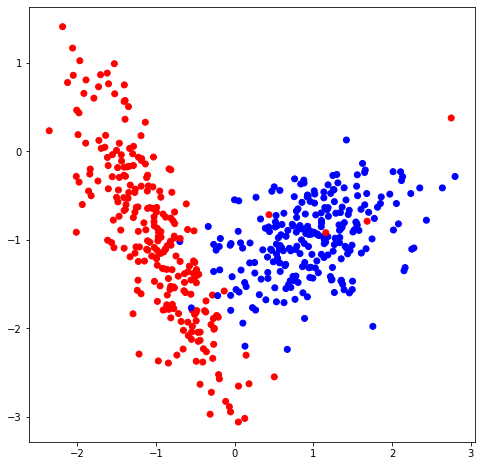

In [146]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [147]:
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [148]:
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction  

In [149]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [150]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [151]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [152]:
#Наилучшее разбиение

def find_best_split(data, labels):
    
    #минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        #уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [153]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [154]:
def classify_object(obj, node):

    #Останавливка рекурсии, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [155]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [156]:
#Ход дерева
def print_tree(node, spacing=""):

    #Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    #Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    #Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    #Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [157]:
#Введем функцию подсчета точности, как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [158]:
#Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [159]:
#Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf):
    
    #Минимальное количество объектов в узле(если не задано, то приравниваем к 1)
    min_leaf = min_leaf if min_leaf else 1
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        #Проверка только уникальных значений признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #Пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #Выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [160]:
#Построение дерева с помощью рекурсивной функции, 
#добавлено ограничение глубины, и минимальное количество элементов в листе:

def build_tree(data, labels, max_depth=None, min_leaf=None):
    
    #Если глубина не задана, будем строить по максимуму
    max_depth=max_depth if max_depth!=None else data.shape[0]*data.shape[1]

    quality, t, index = find_best_split(data, labels, min_leaf)

    #Базовый случай - прекращаем рекурсию, когда нет прироста в качества, или достигли максимальной глубины
    if quality == 0 or max_depth==0 :
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    #Рекурсивно строим два поддерева, уменьшая их глубину
    true_branch = build_tree(true_data, true_labels,max_depth=max_depth-1,min_leaf=min_leaf)
    false_branch = build_tree(false_data, false_labels,max_depth=max_depth-1, min_leaf=min_leaf)

    #Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [161]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, classification_labels, test_size = 0.3, random_state = 1
)

In [162]:
my_tree = build_tree(train_data, train_labels, max_depth=6, min_leaf=15)

In [163]:
print_tree(my_tree)

Индекс 0
Порог -0.051771417967220734
--> True:
  Индекс 0
  Порог -0.36637542342372253
  --> True:
    Индекс 0
    Порог -0.7126883788993976
    --> True:
      Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.5461920538469813
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Индекс 1
  Порог -1.6445609784573159
  --> True:
    Прогноз: 1
  --> False:
    Индекс 0
    Порог 1.1573428257768366
    --> True:
      Прогноз: 1
    --> False:
      Индекс 0
      Порог 1.2787031753893066
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1


In [164]:
train_answers = predict(train_data, my_tree)

In [165]:
answers = predict(test_data, my_tree)

In [166]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.14285714285714

In [167]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

92.66666666666666

<ipython-input-168-066be91aa833>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-168-066be91aa833>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


Text(0.5, 1.0, 'Test accuracy=92.67')

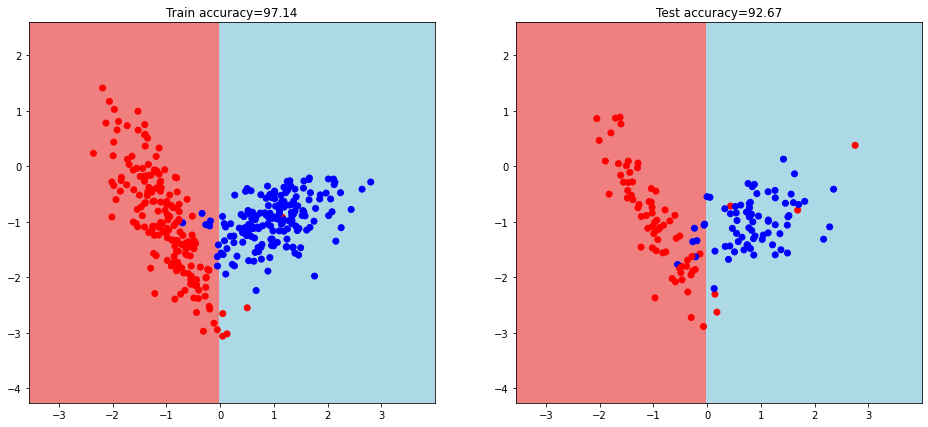

In [168]:
plt.figure(figsize = (16, 7))

plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

In [169]:
#Расчет критерия энтропии

def entropy(labels):
    #Подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #Расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p*np.log2(p) if p!=0 else 0
    
        
    return impurity

In [170]:
#Расчет качества  в зависимости от переданного критерия

def quality(left_labels, right_labels, current_criterion, criterion):

    #Доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    if criterion=='entropy':
        qual=current_criterion - p * entropy(left_labels) - (1 - p) * entropy(right_labels)
    else:
        qual=current_criterion - p * gini(left_labels) - (1 - p) * gini(right_labels)  
    
    return qual

In [171]:
#Нахождение наилучшего разбиения

def find_best_split(data, labels, min_leaf, criterion):
    
    #Минимальное количество объектов в узле(если не задано, то приравниваем к 1)
    min_leaf = min_leaf if min_leaf else 1
    #Критерий оценки
    current_criterion = entropy(labels) if criterion=='entropy' else gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        #Проверка только уникальных значений признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #Пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criterion, criterion)
            
            #Порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index
    return best_quality, best_t, best_index

In [172]:
# Построение дерева с помощью рекурсивной функции, добавлено ограничение глубины, и минимальное 
# количество элементов в листе
# А также выбираем критерий оценки (по умолчанию 'Gini')

def build_tree(data, labels, max_depth=None, min_leaf=None,criterion='Gini'):
    
    # Если глубина не задана, будем строить по максимуму
    max_depth=max_depth if max_depth!=None else data.shape[0]*data.shape[1]

    quality, t, index = find_best_split(data, labels, min_leaf, criterion)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества, или достигли максимальной глубины
    if quality == 0 or max_depth==0 :
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева, уменьшая их глубину
    true_branch = build_tree(true_data, true_labels,max_depth=max_depth-1,min_leaf=min_leaf, criterion=criterion)
    false_branch = build_tree(false_data, false_labels,max_depth=max_depth-1, min_leaf=min_leaf, criterion=criterion)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [173]:
my_tree1 = build_tree(train_data, train_labels, max_depth=2, min_leaf=15, criterion='entropy')

In [178]:
#Ответы для обучающей выборки 
train_answers = predict(train_data, my_tree1)

In [179]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree1)

In [180]:
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

97.14285714285714

In [181]:
#Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

92.66666666666666